# Tensorflow transform

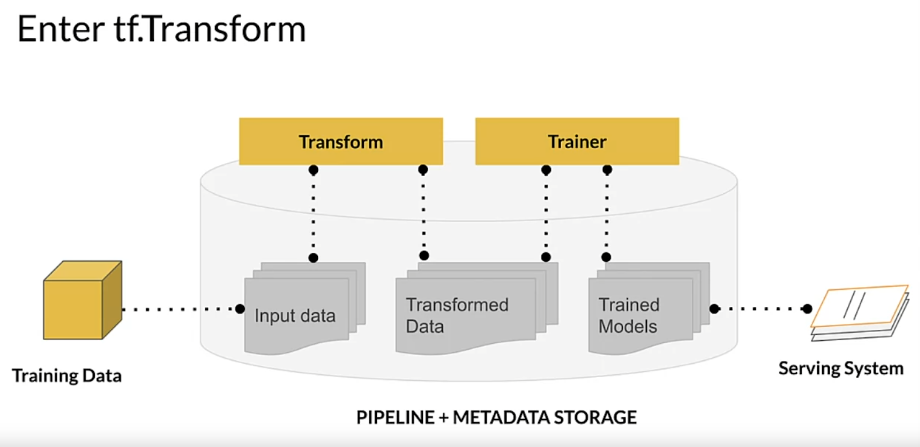

## Importing packages

In [1]:
import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_transform.beam as tft_beam

from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import schema_utils

import pprint
import tempfile

In [2]:
print(f"Tensorflow version : {tf.__version__}")
print(f"TFX transform version : {tft.__version__}")

Tensorflow version : 2.12.0
TFX transform version : 1.13.0


## Defining raw data

In [3]:
raw_data = [
    {'x': 1, 'y': 1, 's': 'hello world'},
    {'x': 2, 'y': 2, 's': 'world'},
    {'x': 3, 'y': 3, 's': 'hello'}
]

## Defining metadata 

In [4]:
#dfine the schema as a DatasetMeatadata object
raw_data_metadata = dataset_metadata.DatasetMetadata(
                
                #Use convenience function to build a schema protobuf
                schema_utils.schema_from_feature_spec({
                    
                    #define a dictionary mapping the keys to its feature spec type
                    'y' : tf.io.FixedLenFeature([], tf.float32),
                    'x' : tf.io.FixedLenFeature([], tf.float32),
                    's' : tf.io.FixedLenFeature([], tf.string)
                })
)


In [5]:
print(raw_data_metadata._schema)

feature {
  name: "s"
  presence {
    min_fraction: 1
  }
  shape {
  }
  type: BYTES
}
feature {
  name: "x"
  presence {
    min_fraction: 1
  }
  shape {
  }
  type: FLOAT
}
feature {
  name: "y"
  presence {
    min_fraction: 1
  }
  shape {
  }
  type: FLOAT
}



## Creating preprocessing function

In [6]:
def preprocessing_fn(inputs):
    '''
    Preprocessing input columns into transformed columns
    '''
    
    x = inputs['x']
    y = inputs['y']
    s = inputs['s']
    
    #data transformation
    x_centered = x - tft.mean(x)
    y_normalized = tft.scale_to_0_1(y)
    s_integerized = tft.compute_and_apply_vocabulary(s)
    x_centered_times_y_normalized = (x_centered * y_normalized)
    
    return {
        'x_centered': x_centered,
        'y_normalized': y_normalized,
        's_integerized': s_integerized,
        'x_centered_times_y_normalized': x_centered_times_y_normalized,
    }

## Creating a graph

In [9]:
tf.get_logger().setLevel('ERROR')

with tft_beam.Context(temp_dir = tempfile.mkdtemp()):
    
    transformed_dataset, transform_fn = (
        (raw_data, raw_data_metadata) | tft_beam.AnalyzeAndTransformDataset(
                                                preprocessing_fn
                                    )
    )
    
transformed_data, transformed_metadata = transformed_dataset

print('\nRaw data:\n{}\n'.format(pprint.pformat(raw_data)))
print('Transformed data:\n{}'.format(pprint.pformat(transformed_data)))


Raw data:
[{'s': 'hello world', 'x': 1, 'y': 1},
 {'s': 'world', 'x': 2, 'y': 2},
 {'s': 'hello', 'x': 3, 'y': 3}]

Transformed data:
[{'s_integerized': 1,
  'x_centered': -1.0,
  'x_centered_times_y_normalized': -0.0,
  'y_normalized': 0.0},
 {'s_integerized': 0,
  'x_centered': 0.0,
  'x_centered_times_y_normalized': 0.0,
  'y_normalized': 0.5},
 {'s_integerized': 2,
  'x_centered': 1.0,
  'x_centered_times_y_normalized': 1.0,
  'y_normalized': 1.0}]
